# 分析PTT汽車版電動車相關文章之詞彙關係

**Group:** 4<br>
**Author:** 董庭妤<br>
**Date created**: 2023/04/12  
**Last modified**: 2023/04/20<br><br> 

In [45]:
# pip install -U networkx

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import re
import jieba
import jieba.analyse
import math
from nltk import ngrams
from nltk import FreqDist
from collections import Counter, namedtuple
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from numpy.linalg import norm

In [47]:
plt.rcParams['font.sans-serif']=['SimHei'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus']=False #使負號能夠顯示

## 資料前處理

### 基本資料介紹
資料來源：
+ 工作流程平台蒐集PTT 汽車版(Car)文章
+ 關鍵字:「電動車」(995筆)
+ 時間: 2022-04-01 ~ 2023-04-15

In [48]:
#匯入資料
MetaData = pd.read_csv('./raw_data/car.csv', encoding='UTF-8')
MetaData.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/car/M.1648778137.A.72B....,[受訪]電動汽車充電行為與使用研究(徵受訪者),2022-04-01 09:55:34,edian,car,本文經Munezsu板主核准\n各位Car版的版友好，\n\n我們是\nBLD\nEnerg...,[],61.227.169.165,2022-04-02 00:06:23,ptt
1,2,https://www.ptt.cc/bbs/car/M.1648821343.A.2E5....,[電車]model31年半4萬公里花費,2022-04-01 21:55:39,mk203125,car,人生第一台車\n\n本來滿一年時想發個心得(花費)才發現第一年連保養里程都不到\n\n透天+...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""wuii0306"", ""...",1.34.96.153,2022-04-02 00:06:29,ptt
2,3,https://www.ptt.cc/bbs/car/M.1648894717.A.DDC....,Re:[討論]為什麼Model3越賣越好？,2022-04-02 18:18:33,asdhse,car,發這文，你後悔了嗎？\n現在入門要174萬惹，自從真特黑和假特粉都下去後，就沒有人可以阻止特...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""ISNAKEI"", ""c...",114.137.122.238,2022-04-02 23:29:31,ptt


### 資料清理  
- 去除特殊字元與標點符號

In [49]:
# 移除網址格式
MetaData['sentence'] = MetaData.artContent.apply(lambda x: re.sub('(http|https)://.*', '', x))
# 只留下中文字
MetaData['sentence'] = MetaData.artContent.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '',x))

### 文章斷詞與整理

In [50]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [51]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [52]:
data = MetaData.copy()
data['word'] = data.sentence.apply(getToken)

# 將word欄位展開
data = data.explode('word')

Building prefix dict from C:\Users\dnlki\SOCIAL MEDIA ANALYSIS\proj1\week8\dict\dict.txt.big ...
Dumping model to file cache C:\Users\dnlki\AppData\Local\Temp\jieba.u13a98fbf3c052ace5acc09c752d07638.cache
Loading model cost 1.044 seconds.
Prefix dict has been built successfully.


## 透過結巴斷詞與N-gram幫助建立字典

### Bigram

In [60]:
# 設定 bigram 斷詞 function
def bigram_getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [61]:
car_bigram = MetaData.copy()

car_bigram["word"] = car_bigram.sentence.apply(bigram_getToken)
car_bigram = car_bigram.explode('word')

#### 統計最常出現的bigram組合

In [62]:
# 計算每個組合出現的次數
car_bigram_count = car_bigram.groupby(["word"],as_index=False).size()
car_bigram_count.head()

,word,size
0,一代 中期,1
1,一代 協調,1
2,一代 喜歡,1
3,一代 圓形,1
4,一代 導入,1


In [63]:
# 清除包含英文或數字的bigram組合
fb_filter = list(car_bigram_count["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))
car_bigram_count[fb_filter].sort_values(by=['size'], ascending=False).head(10)

,word,size
80455,續航 里程,131
103632,里程 焦慮,59
108403,電動車 充電,59
109497,電動車 電池,56
11143,傳統 車廠,50
62141,汽車 市場,42
63525,油車 電車,40
22980,可靠性 指數,38
108158,電動 馬達,38
103539,里程 公里,37


## 使用自建字典

In [67]:
# 新增電動車相關自定義字典
jieba.load_userdict('./dict/car_lexicon.txt')

**使用自建辭典進行斷詞與計算**

In [68]:
# 剛才的斷詞結果沒有使用新增的辭典，因此我們重新進行斷詞
data2 = MetaData.copy()
data2['word'] = data2.sentence.apply(getToken)
data2 = data2.explode('word')

In [69]:
# 再次計算各詞彙在各文章中出現的次數
word_count2 = data2.groupby(['artUrl','word'],as_index=False).size()
word_count2.rename(columns={'size': 'count'}, inplace=True)

In [89]:
word_count2

,artUrl,word,count
0,https://www.ptt.cc/bbs/car/M.1648778137.A.72B....,價值,1
1,https://www.ptt.cc/bbs/car/M.1648778137.A.72B....,充電,3
2,https://www.ptt.cc/bbs/car/M.1648778137.A.72B....,創新,2
3,https://www.ptt.cc/bbs/car/M.1648778137.A.72B....,友好,1
4,https://www.ptt.cc/bbs/car/M.1648778137.A.72B....,團隊,1
...,...,...,...
97293,https://www.ptt.cc/bbs/car/M.1681476499.A.5E3....,電池,2
97294,https://www.ptt.cc/bbs/car/M.1681476499.A.5E3....,電車,1
97295,https://www.ptt.cc/bbs/car/M.1681476499.A.5E3....,顯示,1
97296,https://www.ptt.cc/bbs/car/M.1681476499.A.5E3....,養不起,1


## Bigram視覺化

In [70]:
# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist()
def bigram_getToken_dict(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    bigramfdist.update(ngrams(seg_list, 2))
    seg_list2 = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list2)]
    return seg_list

In [71]:
car_bigram2 = MetaData.copy()
car_bigram2["word"] = car_bigram2.sentence.apply(bigram_getToken_dict)

In [72]:
car_bigram2 = car_bigram2.explode('word')

In [73]:
# 建立bigram和count的dictionary
# 這裡取最多的前50項
d = {k:v for k,v in bigramfdist.most_common(50)}

In [74]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v)
    
# 取得edge權重
weights = [w[2]['weight']*0.01 for w in  G.edges(data=True)]

In [75]:
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

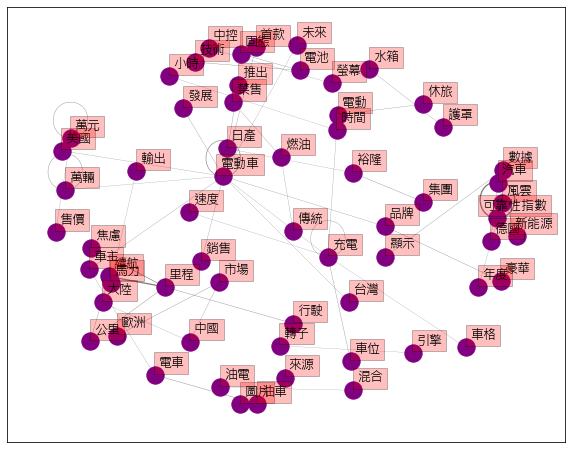

In [76]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

## Pairwise correlation
計算兩個詞彙間的相關性 Phi相關係數(Phi coefficient)  

In [77]:
# 取常一起出現的bigram pair 前1500筆
b = {k:v for k,v in bigramfdist.most_common(1500)}

In [78]:
# 建立DataFrame
bigram_df = pd.DataFrame(list(b), columns=['word','word2']).assign(n=b.values())

In [79]:
#計算phi值
def phi_cor(df):
    # total x
    nx = len(set(word_count2[word_count2["word"]==df["word"]]["artUrl"]))
    tnx = len(MetaData)-nx
    # total y
    ny = len(set(word_count2[word_count2["word"]==df["word2"]]["artUrl"]))
    tny = len(MetaData)-ny
    # 有x 有y
    x_ls = list(word_count2[word_count2["word"]==df["word"]]["artUrl"]) #單獨有x
    y_ls = list(word_count2[word_count2["word"]==df["word2"]]["artUrl"]) #單獨有y
    nxy = len(set(x_ls)&set(y_ls)) #取交集
    # 有x 沒有y
    nxo = nx-nxy
    # 沒有x 沒有y
    uxy = set(x_ls)|set(y_ls) #取聯集
    noo = len(set(list(MetaData["artUrl"]))-uxy) #取差集:全-有x有y
    # 沒有x 有y
    noy = ny-nxy
    # print(nx,ny,tny,tnx,nxy,noo,nxo,noy)
    phi = (nxy*noo-nxo*noy)/math.sqrt(nx*ny*tny*tnx)
    
    return phi

In [80]:
bigram_df["cor"] = bigram_df.apply(phi_cor, axis=1)
bigram_df = bigram_df[bigram_df["word"]!=bigram_df["word2"]]

### 使用詞彙關係圖畫出相關性大於0.6的組合

In [81]:
bigram_df[bigram_df["cor"]>0.6]

,word,word2,n,cor
28,水箱,護罩,25,0.828637
457,磷酸,鐵鋰,7,0.676958
491,隨油,徵收,7,0.773815
591,會員,驗證,7,0.662939
609,噸純,電大,7,1.000000
842,佐藤,恆治,6,0.816085
1109,公路交通,管理局,5,0.754784
1216,俄羅斯,烏克蘭,4,0.621960
1490,存證,信函,4,1.000000


In [82]:
word_cors = bigram_df[bigram_df["cor"]>0.6]
word_cors.reset_index(inplace=True, drop=True)

In [83]:
import networkx as nx
# Create network plot 
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(word_cors)):
    g.add_edge(word_cors["word"][i], word_cors["word2"][i], weight=word_cors["cor"][i])
    
# 取得edge權重
weights = [w[2]['weight']*10 for w in  g.edges(data=True)]

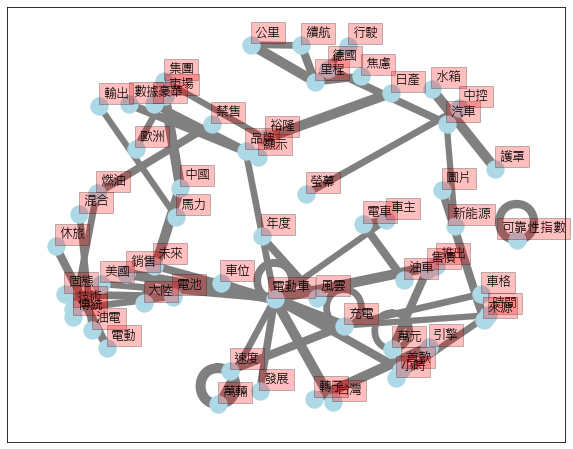

In [84]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()